# 线性回归基本要素

### 模型

线性回归假设输出与各个输入之间是线性关系。
$$
\mathrm{price} = w_{\mathrm{area}} \cdot \mathrm{area} + w_{\mathrm{age}} \cdot \mathrm{age} + b
$$

### 损失函数
$$
l^{(i)}(\mathbf{w}, b) = \frac{1}{2} \left(\hat{y}^{(i)} - y^{(i)}\right)^2,
$$



$$
L(\mathbf{w}, b) =\frac{1}{n}\sum_{i=1}^n l^{(i)}(\mathbf{w}, b) =\frac{1}{n} \sum_{i=1}^n \frac{1}{2}\left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right)^2.
$$

### 优化函数 - 随机梯度下降
当模型和损失函数形式较为简单时，上面的误差最小化问题的解可以直接用公式表达出来。这类解叫作解析解（analytical solution）。本节使用的线性回归和平方误差刚好属于这个范畴。然而，大多数深度学习模型并没有解析解，只能通过优化算法有限次迭代模型参数来尽可能降低损失函数的值。这类解叫作数值解（numerical solution）。

在求数值解的优化算法中，小批量随机梯度下降（mini-batch stochastic gradient descent）在深度学习中被广泛使用。它的算法很简单：先选取一组模型参数的初始值，如随机选取；接下来对参数进行多次迭代，使每次迭代都可能降低损失函数的值。在每次迭代中，先随机均匀采样一个由固定数目训练数据样本所组成的小批量（mini-batch）$\mathcal{B}$，然后求小批量中数据样本的平均损失有关模型参数的导数（梯度），最后用此结果与预先设定的一个正数的乘积作为模型参数在本次迭代的减小量。   

$$
(\mathbf{w},b) \leftarrow (\mathbf{w},b) - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \partial_{(\mathbf{w},b)} l^{(i)}(\mathbf{w},b)
$$
  
学习率: $\eta$代表在每次优化中，能够学习的步长的大小    
批量大小: $\mathcal{B}$是小批量计算中的批量大小batch size   

总结一下，优化函数的有以下两个步骤：

- (i)初始化模型参数，一般来说使用随机初始化；
- (ii)我们在数据上迭代多次，通过在负梯度方向移动参数来更新每个参数。

# 线性回归模型从0开始实践

In [1]:
%matplotlib inline
import torch
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import random

print(torch.__version__)

1.1.0


### 生成数据集

In [2]:
num_feature = 2
num_example= 1000

true_w = [2, -3.4]
true_b = 4.2

data = torch.randn(num_example, num_feature, dtype=torch.float32)
labels = true_w[0] * data[:, 0] + true_w[1] * data[:, 1] + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float32)

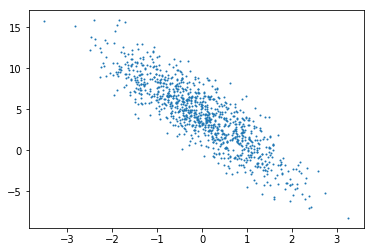

In [3]:
plt.scatter(data[:,1].numpy(), labels.numpy(), 1)

### 读取数据集

In [6]:
def data_iter(batch_size, data, labels):
    num_examples = len(data)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        j = torch.LongTensor(indices[i : min(i+batch_size, num_examples)])
        yield data.index_select(0,j), labels.index_select(0,j) # 0 表示维度，在行上选择， 1表示在列上选择；

In [7]:
batch_size = 10
for X, y in data_iter(batch_size, data, labels):
    print(X, '\n', y)
    break

tensor([[ 1.1360, -1.0317],
        [-0.9713,  1.2386],
        [ 1.2361, -0.9361],
        [ 1.0250, -0.4855],
        [-1.6387,  0.3702],
        [ 0.9604, -0.3517],
        [ 0.8711, -0.6729],
        [ 1.2880, -0.5643],
        [-1.7172, -0.2194],
        [-0.5601, -0.9561]]) 
 tensor([ 9.9801, -1.9550,  9.8352,  7.8930, -0.3290,  7.3122,  8.2182,  8.7130,
         1.5051,  6.3149])


### 初始化模型参数

In [8]:
w = torch.tensor(np.random.normal(0,0.01,(num_feature, 1)), dtype=torch.float32)
b = torch.zeros(1, dtype=torch.float32)
w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True)

tensor([0.], requires_grad=True)

### 定义模型

In [9]:
def linreg(X, w, b):
    return torch.mm(X, w) + b

### 定义损失函数

In [10]:
def squared_loss(y_pred, y_true):
    return (y_pred - y_true.view(y_pred.size())) ** 2 /2

### 定义优化函数

In [11]:
def sgd(params, lr, batch_size):
    for param in params:
        param.data -= lr * param.grad / batch_size

### 训练

In [12]:
lr = 0.03
num_epochs = 5

net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, data, labels):
        y_pred = net(X, w, b)
        l = loss(y_pred, y).sum()
        l.backward()
        sgd([w,b], lr, batch_size)
        w.grad.data.zero_()
        b.grad.data.zero_()
    train_loss = loss(net(data, w, b), labels)
    print('epoch %d, loss %f' %(epoch + 1, train_loss.mean().item()))

epoch 1, loss 0.027925
epoch 2, loss 0.000096
epoch 3, loss 0.000052
epoch 4, loss 0.000051
epoch 5, loss 0.000051


In [13]:
w, true_w, b, true_b

(tensor([[ 2.0003],
         [-3.4002]], requires_grad=True),
 [2, -3.4],
 tensor([4.1999], requires_grad=True),
 4.2)

# pytorch 简洁实现

In [14]:
import torch 
from torch import nn
torch.manual_seed(1)

torch.set_default_tensor_type('torch.FloatTensor')

### 读取数据集

In [15]:
import torch.utils.data as Data
batch_size = 10
dataset = Data.TensorDataset(data, labels)
data_iter = Data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, num_workers=2,)

In [16]:
for X,y in data_iter:
    print(X, '\n', y)
    break

tensor([[-0.2296, -1.8227],
        [-1.6629,  0.0849],
        [-0.6833,  0.5444],
        [-0.3136,  0.8633],
        [ 0.1241, -0.4174],
        [ 0.0324, -0.4194],
        [-1.8120,  1.9638],
        [-0.3237, -0.7568],
        [ 1.3560,  0.5598],
        [ 0.4693,  0.7415]]) 
 tensor([ 9.9108,  0.5716,  0.9794,  0.6465,  5.8861,  5.6957, -6.1087,  6.1365,
         5.0179,  2.6208])


### 定义模型

In [20]:
class LinearNet(nn.Module):
    def __init__(self, n_feature):
        super(LinearNet, self).__init__()
        self.linear = nn.Linear(n_feature, 1)
        nn.init.normal_(self.linear.weight,  mean=0.0, std=0.01)
        nn.init.constant_(self.linear.bias, val=0.0)
    def forward(self, x):
        y = self.linear(x)
        return y
net = LinearNet(num_feature)
print(net)

LinearNet(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)


### 定义损失函数

In [21]:
loss = nn.MSELoss()

### 定义优化函数

In [22]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.03)
print(optimizer)

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.03
    momentum: 0
    nesterov: False
    weight_decay: 0
)


### 训练

In [24]:
num_epochs = 5
for epoch in range(num_epochs):
    for X, y in data_iter:
        y_pred = net(X)
        l = loss(y_pred, y.view(-1,1))
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    print('epoch %d, loss: %f' % (epoch+1, l.item()))

epoch 1, loss: 0.000190
epoch 2, loss: 0.000273
epoch 3, loss: 0.000101
epoch 4, loss: 0.000090
epoch 5, loss: 0.000144
